In [4]:
import torch
from src.utils.model import freeze_layer
state_dict = torch.load('weight\model_finetune_arcface_k=1_best.pth', map_location= 'cpu')['model_state_dict']

In [28]:
from src.utils.eval import *
from src.data import *

def accuracy(root, weight_path: str,  threshold = 0.6, dataset_test=None, seed=1):
  torch.manual_seed(seed)
  val_model = get_test_model(weight_path, 'weight/backbone_r100_glint360k.pt').cuda()
  val_model.eval()

  if dataset_test is None:
    dataset_test = TripletFaceDataset(root, 10, augment=False)
  
  test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=1,
                                       shuffle=True, drop_last = True)
  
  cos = nn.CosineSimilarity(dim=0, eps=1e-6)
  gt =[]
  pr = []
  for a,p,n, _, _, _ in tqdm(test_loader):
    a_out,p_out,n_out = val_model(a.cuda(), p.cuda(),n.cuda())

    # a_out = get_embeded(a)
    # p_out = get_embeded(p)
    # n_out = get_embeded(n)
    # a_out , p_out = get_embeded_vecto(a[0],p[0])

    # a_out , n_out = get_embeded_vecto(a[0],n[0])

    # # print((a_out-n_out).mean())
    distance_ap = cos(a_out[0],p_out[0])
    # print(distance_ap)
    gt.append(1)
    pr.append(max(0,distance_ap.item()))
    distance_an = cos(a_out[0],n_out[0])
    # print(distance_an)
    gt.append(0)
    pr.append(max(0,distance_an.item()))
    pr_binary = []
    for i in range (len(pr)):
      if pr[i]>threshold:
        pr_binary.append(1)
      else:
        pr_binary.append(0)
  pr_binary = np.array(pr) > threshold

  c_m = cm(gt,pr_binary)
  precision = precision_score(gt,pr_binary)
  recall = recall_score(gt,pr_binary)
  F1_score = f1_score(gt,pr_binary)
  
  accuracy = accuracy_score(gt,pr_binary)
  return F1_score



dataset_test = TripletFaceDataset('Data\Data_test', 10, augment=False)
f1s = [
accuracy('Data\Data_test',None, 0.3, seed=seed, dataset_test=dataset_test) for seed in range(3)]

100%|██████████| 1000/1000 [02:57<00:00,  5.64it/s]


In [29]:
for score in f1s:
    print(score)

0.9340314136125655
0.9112299465240641
0.9197235513024987


In [27]:
for score in f1s:
    print(score)

0.17351598173515984
0.18016378525932666
0.17184643510054842
0.17017383348581885
0.18181818181818182


In [ ]:
from src.utils.model import get_triplet_model, get_test_model
model = get_test_model(weight_path= None, init_weight='weight/backbone_r100_glint360k.pt')
model = model.cuda()
model.eval()

In [7]:
from src.utils.eval import *
from src.data_colab import *
dataset_test = TripletFaceDataset_colab(['Data\dataset_umd', 'Data\VN-celeb', 'Data\casia_webface_imgs', 'Data\Data_train' ], 1, augment=False)

18948


In [8]:
with open('train_triplet.txt', 'w') as f:
    for index in range(100000):
        a, p, n, a_label, p_label, n_label = dataset_test.get_anchor_positive_negative_paths(index)
        f.writelines(f'{a} {p} {n} {a_label} {p_label} {n_label}\n')



In [8]:
with open('train_triplet.txt','r+') as f:
    triplet_paths = f.readlines()
    triplet_paths = [path.strip() for path in triplet_paths]

In [ ]:
triplet_paths

In [ ]:
tmp_list = []
for path in triplet_paths:
    tmp_ele = path.strip()
    tmp_list.append(tmp_ele)
triplet_paths = tmp_ele

In [119]:
def get_person_image_paths(paths_person_set: list) -> dict:
    """Creates mapping from person name to list of images.
    Args:
        path_person_set (str): Path to dataset that contains folder of images.
    Returns:
        Dict[str, List]: Mapping from person name to image paths,
                         For instance {'name': ['/path/image1.jpg', '/path/image2.jpg']}
    """
    # path_person_set = Path(path_person_set)
    # person_paths = filter(Path.is_dir, path_person_set.glob('*'))
    person_paths = []
    weight_list = []
    for folder_path in paths_person_set:
        folder_len = len(os.listdir(folder_path))
        for person_path in os.listdir(folder_path):
            weight_list.append(1/folder_len)
            person_paths.append(Path(folder_path + '/' + person_path))
    return {
        str(path.parent).replace('\\','_') + path.name :[list(str(path)+'/'+file for file in list(os.listdir(path))), weight_list[idx]]  for idx, path in enumerate(person_paths)
    }
    

In [120]:
def get_persons_with_at_least_k_images(person_paths: dict, k: int) -> list:
    """Filter persons and return names of those having at least k images
    Args:
        person_paths (dict): dict of persons, as returned by `get_person_image_paths`
        k (int): number of images to filter for
    Returns:
        list: list of filtered person names
    """
    return [[name,weight] for name, (paths,weight) in person_paths.items() if len(paths) >= k] 

In [125]:
person_paths= get_person_image_paths(paths_person_set = ['Data\check_code\Data_Cam_cropped_test1', 'Data\check_code\Data_test']) 
_, weight_list = zip(*get_persons_with_at_least_k_images(person_paths, 2))
# person_paths

In [ ]:
from src.utils.model import get_triplet_model, get_test_model
model = get_test_model(weight_path= None, init_weight='weight/backbone_r100_glint360k.pt')
model = model.cuda()
model.eval()

In [ ]:
with torch.no_grad(): 
    with open('train_triplet.txt','r+') as f:
        triplet_paths = f.readlines()
        triplet_paths = [path.strip() for path in triplet_paths]
    for triplet in triplet_paths:
        print(triplet.split())


In [2]:
from src.data import *
import torch
from tqdm import tqdm
from torchvision.transforms import functional as TF
from matplotlib import pyplot as plt 
import torch.nn as nn
list_cs = []
count = 0
with torch.no_grad(): 
    dataset_test = Triplet_loader('valid_triplet.txt')
    for idx, (a,p,n,_,_,_) in tqdm(enumerate(dataset_test)):

        a,p,n = a.unsqueeze(0).cuda(), p.unsqueeze(0).cuda(), n.unsqueeze(0).cuda()

        ea, ep, en = model(a,p,n)
        cs = nn.CosineSimilarity()
        dis_ap = cs(ea,ep)[0].item()
        if dis_ap > 0.3:
            count += 1
            with open("valid_triplet.txt", "r") as input:
                lines = input.readlines()
            with open("valid_triplet_processed.txt", "a") as output:
                    output.write(lines[idx])
                                    

            # img: torch.Tensor = torch.cat([a.squeeze(0).cpu(), p.squeeze(0).cpu(), n.squeeze(0).cpu()], axis=-1)
            # img = (img - img.min()) / (img.max() - img.min())
            # img = (TF.to_pil_image(img))
            
            # plt.imshow(img)
            # plt.show()

        # dis_an = cs(ea,en)[0].item()
        # dis_pn = cs(ep,en)[0].item()
        # list_cs.append((dis_ap, dis_an, dis_pn))
        


print(count)


10000it [18:10,  9.17it/s]

8737


In [8]:
import numpy as np
np.asarray(list_cs).mean(0)

array([0.51781941, 0.01465562, 0.01679906])

100%|██████████| 1000/1000 [01:40<00:00,  9.93it/s]

precision: 1.0
recall: 0.114
F1 score: 0.2046678635547576
Accuracy: 0.557


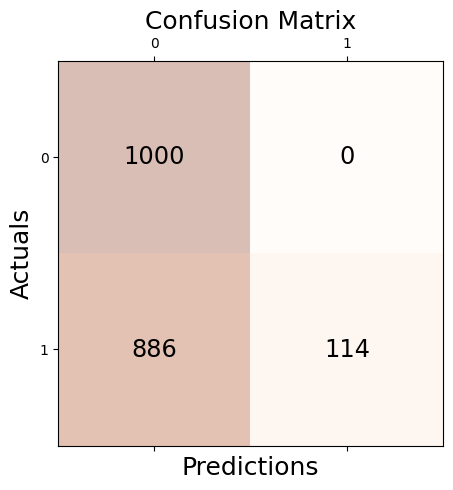

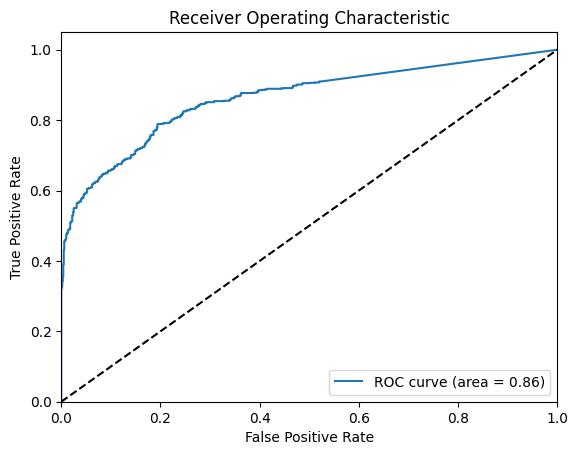

Best threshold: 0.04896406829357147
precision: 0.8026449643947101
recall: 0.789
F1 score: 0.7957639939485629
Accuracy: 0.7975


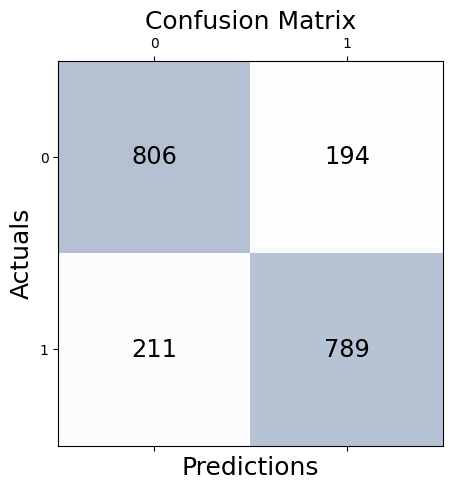

In [3]:
from src.utils.eval import accuracy
import torch

torch.manual_seed(100)
accuracy('Data\Data_test','weight/resnet100_400.pth', 0.3)  

Data\Data_test\3/IMG_1946.png Data\Data_test\3/2_frame8.jpg Data\Data_test\69/1_frame6.jpg


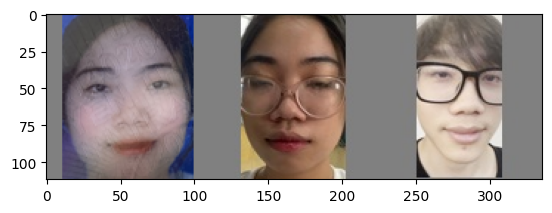

Data\Data_test\23/Copy of IMG_20230215_111804.jpg Data\Data_test\23/2_frame8.jpg Data\Data_test\22/2_frame2.jpg


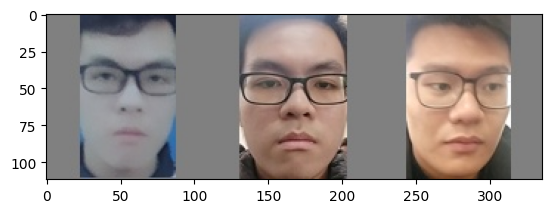

Data\Data_test\69/IMG_7597.png Data\Data_test\69/1_frame6.jpg Data\Data_test\107/1_frame12.jpg


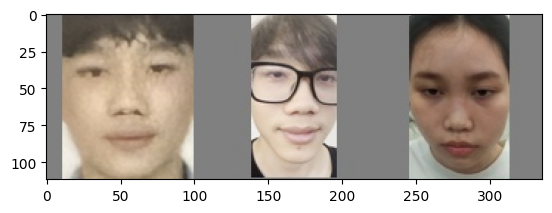

Data\Data_test\68/IMG_4357.png Data\Data_test\68/1_frame15.jpg Data\Data_test\67/2_frame6.jpg


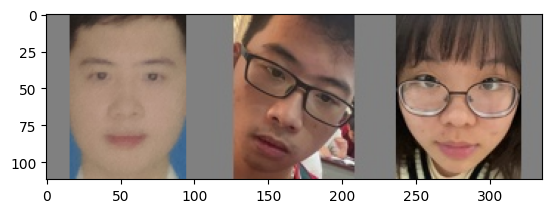

Data\Data_test\57/IMG_4578.png Data\Data_test\57/1_frame6.jpg Data\Data_test\16/1_frame13.jpg


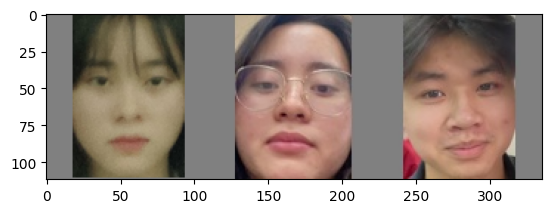

Data\Data_test\48/IMG_4523.png Data\Data_test\48/2_frame13.jpg Data\Data_test\24/3_frame3.jpg


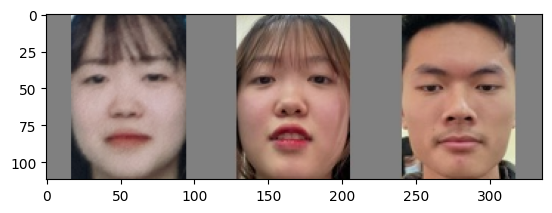

Data\Data_test\71/20230215_132906.jpg Data\Data_test\71/1_frame10.jpg Data\Data_test\47/2_frame6.jpg


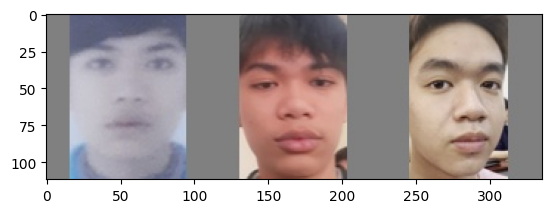

Data\Data_test\87/Copy of IMG_20230215_130830.jpg Data\Data_test\87/1_frame12.jpg Data\Data_test\106/3_frame13.jpg


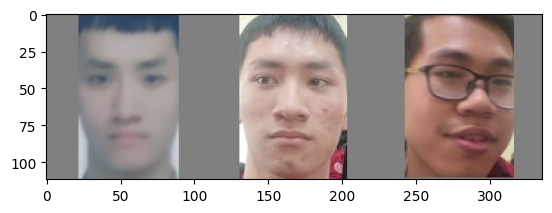

Data\Data_test\49/20221031_094214.jpg Data\Data_test\49/2_frame12.jpg Data\Data_test\16/1_frame13.jpg


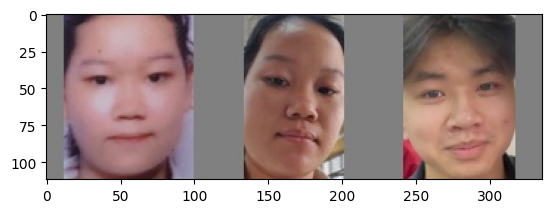

Data\Data_test\84/Bản sao của 20230215_133920.jpg Data\Data_test\84/1_frame15.jpg Data\Data_test\107/2_frame12.jpg


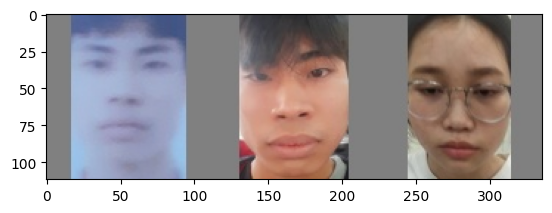

In [16]:
from torch.utils.data import Dataset
from src.data import *
class TripletFaceDataset(Dataset):

    def __init__(self, path, scale = 1, augment=False) -> None:
        super().__init__()

        self.scale = int(scale)

        self.person_paths = get_person_image_paths(path)
        self.persons = self.person_paths.keys()
        self.persons_positive = get_persons_with_at_least_k_images(self.person_paths, 2)

        if augment:
            self.transform = transforms.Compose(
                [transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.GaussianBlur((5,5)),
                transforms.RandomRotation(30),
                transforms.ColorJitter(0.4, 0.3, 0.2, 0.1),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ])
        else:
            self.transform = transforms.Compose(
                [
                transforms.ToTensor(),
                # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                ])

    def get_anchor_positive_negative_paths(self, index: int) -> tuple:
        """Randomly sample a triplet of image paths.
        Args:
            index (int): Index of the anchor / positive person.
        Returns:
            tuple[Path]: A triplet of paths (anchor, positive, negative)
        """

        # TODO Please implement this function
        
        
        # while len(list_anchor_img) == 0:
        if not self.persons_positive:
          raise ValueError("No positive persons available in the dataset.")
        # index = random.randint(0, len(self.persons_positive))
        # person = list(self.persons_positive)[index] # get the anchor person
        person = random.choice(list(self.persons_positive))
        list_person_img = self.person_paths[person][:] # images of the same person
        a_label = list(self.persons_positive).index(person)
        p_label = list(self.persons_positive).index(person)
        # print(list_person_img)
        list_anchor_img = []
       
        for anchor in list_person_img:
          if 'frame' not in os.path.basename(anchor.lower()):
            list_anchor_img.append(anchor)
            list_person_img.remove(anchor) # avoid taking the same image as positive 
          else:
            continue
        if not list_anchor_img:
          # Replace with a random image from the person's images
          a = random.choice(list_person_img)
        else:
          a = random.choice(list_anchor_img)  # get an anchor example

        # if not list_anchor_img:
        #   raise ValueError("No suitable anchor image found for person: " + person)
       
        p = random.choice(list_person_img) # get a positive example
        # get a negative person
        n_person = random.choice(list(self.persons_positive))
        while n_person == person:
            n_person = random.choice(list(self.persons_positive))
        n_label = list(self.persons_positive).index(n_person)
        list_nega_img = self.person_paths[n_person]
        list_nega_choose =[]
        for nega_img in list_nega_img:
          # print(nega_img)
          if 'frame' in os.path.basename(nega_img):
            list_nega_choose.append(nega_img)
          else:
            continue
        
        n = random.choice(list_nega_choose) # get a negative example
        return a, p, n, a_label, p_label, n_label


    def __getitem__(self, index: int):
        """Randomly sample a triplet of image tensors.
        Args:
            index (int): Index of the anchor / positive person.
        Returns:
            tuple[Path]: A triplet of tensors (anchor, positive, negative)
        """
        a, p, n, a_label, p_label, n_label = self.get_anchor_positive_negative_paths(index)
        # print(a,p,n,sep = '\n')
        print(a, p, n)
        return (
            self.transform(load_image(a)),
            self.transform(load_image(p)),
            self.transform(load_image(n)),
            a_label, p_label, n_label
        )

    def __len__(self):
        return self.scale * len(self.persons_positive)

ds = TripletFaceDataset("Data/Data_test/")
from torchvision.transforms import functional as TF
from matplotlib import pyplot as plt 
for i in range(10):
   a, p, n, _, _, _  = ds[i]
   img = torch.cat([a, p, n], axis=-1)
   img = (TF.to_pil_image(img))
   plt.imshow(img)
   plt.show()